# Modelo PAC (Passive Agressive Classifier)

In [1]:
%matplotlib inline

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import PassiveAggressiveClassifier

In [ ]:
sys.path.append(os.path.abspath("../funciones"))

from funcionesEntrenamiento import (
    cargar_datos_entrenamiento,
    cargar_datos_prueba,
    imprimir_forma,
    division_train_val,
    reporte_clasificacion,
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
    hacer_pepinillo
)

In [3]:
# Cargar datos y separar características y columna con las clases con función
X, y = cargar_datos_entrenamiento()

shape, head = imprimir_forma(X)
print("Shape: ", shape)
head

Shape:  (1500, 1368)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1290,tfidf_1291,tfidf_1292,tfidf_1293,tfidf_1294,tfidf_1295,tfidf_1296,tfidf_1297,tfidf_1298,tfidf_1299
0,0.242191,-0.059671,0,0,0,0,0,1.173738,0.353420,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.549985,-1.624910,0,0,0,0,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.456454,-0.283276,3,2,0,0,0,0.796212,0.946048,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333319,0.163935,0,0,0,1,0,1.777780,0.649734,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.790588,-0.730488,0,0,0,1,0,-1.317935,0.946048,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Busqueda de mejores parámetros (Entrenamiento y Validación)

In [5]:
# División estratificada (80/20) con función
X_train, X_val, y_train, y_val = division_train_val(X,y)


print(f"Forma de conjunto de entrenamiento:", X_train.shape)
print(f"Forma de conjunto de validación:", X_val.shape)

Forma de conjunto de entrenamiento: (1200, 1368)
Forma de conjunto de validación: (300, 1368)


In [ ]:
# Modelo base para encontrar mejores parámetros
pac = PassiveAggressiveClassifier(random_state=22)

# Parámetros a buscar con GridSearchSV 
param_grid = {
    'C': [0.001, 0.01, 0.1, 10],
    'max_iter': [150, 200, 250, 300, 350],
    'loss': ['hinge', 'squared_hinge']
}

# Cross-validation estratificada
cv = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=22
)

# GridSearch
grid = GridSearchCV(
    estimator=pac, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

In [7]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\z47al\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
             error_score='raise',
             estimator=PassiveAggressiveClassifier(random_state=22), n_jobs=-1,
             param_grid={'C': [0.001], 'loss': ['squared_hinge'],
                         'max_iter': [200]},
             scoring='roc_auc', verbose=1)

In [8]:
# Ver mejores hiperparámetros encontrados
grid.best_params_

{'C': 0.001, 'loss': 'squared_hinge', 'max_iter': 200}

In [9]:
#Creación de modelo con los mejores parámetros
best_pac = PassiveAggressiveClassifier(
    C=0.001,
    max_iter=200,
    loss='squared_hinge',
    random_state=22
)

best_pac.fit(X_train, y_train)

c:\Users\z47al\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


PassiveAggressiveClassifier(C=0.001, loss='squared_hinge', max_iter=200,
                            random_state=22)

In [12]:
# Validación del modelo
y_pred, y_scores, reporte = reporte_clasificacion(X_val, y_val, best_pac, True)

print("Classification Report:")
print(reporte)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       139
           1       0.86      0.89      0.87       161

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



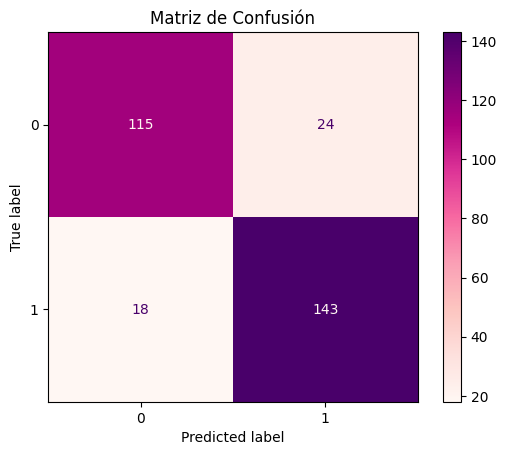

In [ ]:
# Matriz de confusión
cm, disp = crear_matriz_confusion(y_val, y_pred)
disp.plot(cmap="RdPu")
plt.title("Matriz de Confusión")
plt.show()

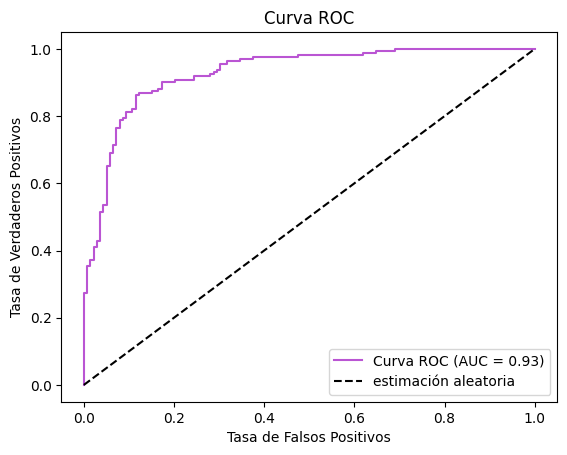

In [14]:
# Predicciones de scores (para curva ROC)
fpr, tpr, thresholds, auc_score = calcular_roc_auc(y_val, y_scores)

# Gráfica de ROC
plt.plot(fpr, tpr, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label='estimación aleatoria')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [25]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR, FPR = metricas_tpr_fpr(cm)

# Mostrar métricas
print(f"AUC: {(auc_score * 100):.4f}")
print(f"TPR (Tasa de Verdaderos Positivos): {(TPR * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR * 100):.4f}")

AUC: 92.7923
TPR (Tasa de Verdaderos Positivos): 88.8199
FPR (Tasa de Falsos Positivos): 17.2662


## Modelo Final (Entrenamiento y Prueba)

In [16]:
# Modelo entrenado con todos los datos de ds_tradicional
modelPAC = PassiveAggressiveClassifier(
    C=0.001,
    max_iter=200,
    loss='squared_hinge',
    random_state=22
)
modelPAC.fit(X, y)

PassiveAggressiveClassifier(C=0.001, loss='squared_hinge', max_iter=200,
                            random_state=22)

In [17]:
# Cargar datos y separar características y columna con las clases con función 
X_test, y_test = cargar_datos_prueba()

shape_test, head_test = imprimir_forma(X_test)
print("Shape: ", shape_test)
head_test

In [18]:
#Prueba del modelo final
y_pred_test, y_scores_test, reporte_test = reporte_clasificacion(X_test, y_test, modelPAC, True)

print("Classification Report:")
print(reporte_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       116
           1       0.82      0.93      0.87       134

    accuracy                           0.85       250
   macro avg       0.86      0.85      0.85       250
weighted avg       0.86      0.85      0.85       250



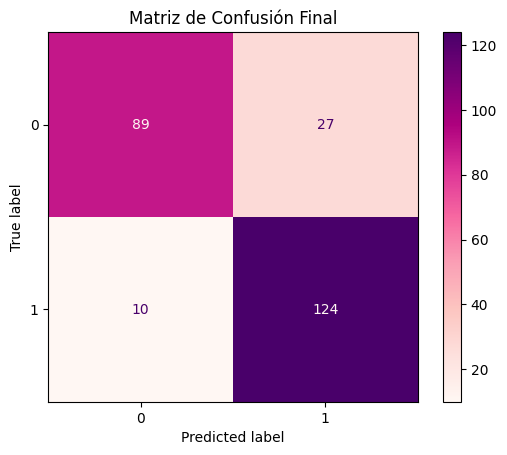

In [ ]:
# Matriz de confusión
cm_test, disp_test = crear_matriz_confusion(y_test, y_pred_test)

disp.plot(cmap="RdPu")
plt.title("Matriz de Confusión Final")
plt.show()

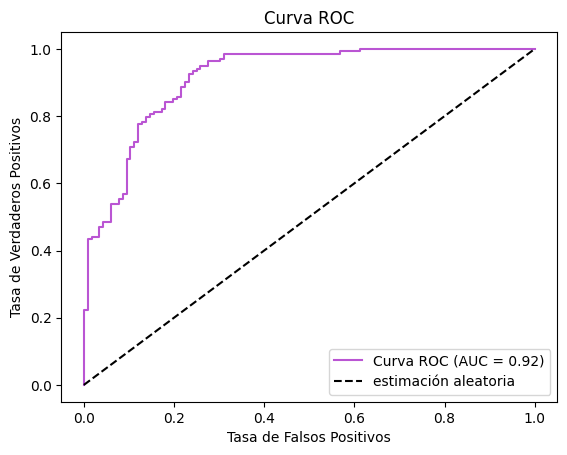

In [ ]:
# Predicciones de probabilidad (para curva ROC)
fpr_test, tpr_test, thresholds_test, auc_score_test = calcular_roc_auc(y_test, y_scores_test)

# Gráfica ROC
plt.plot(fpr_test, tpr_test,color='mediumorchid', label=f"Curva ROC (AUC = {auc_score_test:.2f})")
plt.plot([0, 1], [0, 1], "k--", label='estimación aleatoria')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [24]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_Test, FPR_Test = metricas_tpr_fpr(cm_test)

# Mostrar métricas
print(f"AUC: {(auc_score_test * 100):.4f}")
print(f"TPR (Tasa de Verdaderos Positivos): {(TPR_Test * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR_Test * 100):.4f}")

AUC: 91.5015
TPR (Tasa de Verdaderos Positivos): 92.5373
FPR (Tasa de Falsos Positivos): 23.2759


In [26]:
# Guardado del modelo final en un archivo pickle
hacer_pepinillo(modelPAC, "modelPAC.pkl")